In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [83]:
os.chdir(r'c:\Users\karina mehta\UVA class\UnderstandingUncertainity\git_practice\group_git\snp_data')

In [84]:
sp_comp = pd.read_csv('sp500_companies.csv')
sp_index = pd.read_csv('sp500_index.csv')
sp_stocks = pd.read_csv('sp500_stocks.csv')

# Markov Chain

To model the likelihood of bearish, bullish, or stable days, we split our dataset into a training set (up to 2020) and a test set (2020–2024). For each stock, we calculate the daily percent change in adjusted closing prices and classify each day into one of three states:
Bear: negative percent change (market goes down)


Bull: positive percent change (market goes up)


Stable: percent change within a defined threshold

## Individual Stock level

This classification allows us to generate state sequences for each stock across the years, forming the basis for individual stock transition matrices, which capture the probability of moving from one state to another.

In [85]:
sp_stocks.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1891531,2024-12-16,ZTS,175.809998,175.809998,179.289993,175.789993,177.990005,1938800.0
1891532,2024-12-17,ZTS,170.789993,170.789993,177.320007,169.520004,175.000000,3018300.0
1891533,2024-12-18,ZTS,167.009995,167.009995,170.940002,166.899994,170.070007,2728300.0
1891534,2024-12-19,ZTS,163.520004,163.520004,167.440002,163.369995,166.589996,3713700.0
1891535,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0


In [86]:
sp_stocks = sp_stocks.sort_values(['Date','Symbol'])
#Percent Change of Adj Close from previous day to the next day for each stock
sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()
#First row will return NaN since there is no previous day to compare 
sp_stocks = sp_stocks.dropna(subset=['pct_change'])


C:\Users\karina mehta\AppData\Local\Temp\ipykernel_25092\1342530805.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()


#### Threshold Decision

The threshold defines the range considered Stable. We experimented with values from 0.001 to 0.2. A threshold of 0.001 was small, barely reflecting stable days, while 0.2 was too large, resulting in most days being classified as stable. A threshold of 0.002 (0.2%) was chosen. This captures minor flat days as stable while keeping Bull and Bear proportions realistic.

In [87]:
# Creating state of 'bear' and 'bull'
# Bear: Market is down i.e. negative change
# Bull: Market is up i.e. positive change

threshold = 0.002

def classify_change(x):
    if x > threshold:
        return 'Bull'
    elif x < -threshold:
        return 'Bear'
    else:
        return 'Stable'
    
sp_stocks['State'] = sp_stocks['pct_change'].apply(classify_change)



In [88]:
sp_stocks['State'].value_counts(normalize=True)

State
Bull      0.459165
Bear      0.408890
Stable    0.131945
Name: proportion, dtype: float64

In [89]:
#Individual Markov chain according to each symbol/ticker
train = sp_stocks[sp_stocks['Date'] < '2020-01-01']


ticker = train['Symbol'].unique()
transition_matrices = {}

for t in ticker:
    ticker_state = train[train['Symbol'] == t].sort_values('Date')['State'].values
    transition_matrices[t] = pd.crosstab(ticker_state[:-1], ticker_state[1:], normalize='index')


In [90]:
transition_matrices['CCL']

col_0,Bear,Bull,Stable
row_0,,,
Bear,0.405458,0.461988,0.132554
Bull,0.420779,0.452814,0.126407
Stable,0.375375,0.471471,0.153153


#### Interpretation

From the value counts of our states, we observe that daily movements are almost evenly split between Bull and Bear days, with Stable days accounting for around 13%. Examining a single stock like CCL, we find that it is 40% likely to move from Bear to Bear, 46% from Bear to Bull, and 13% from Bear to Stable, reflecting the randomness of stock movements.



## Sector-Level Analysis

After computing individual stock transition matrices, we aggregate them to the sector level.


In [91]:
#Creating a dataframe for each sector names and marketcap and weight according to symbols and their states
sp_sector = train.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [92]:
sp_sector.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
0,2010-01-05,A,19.835201,22.145924,22.331903,22.002861,22.324751,4186031.0,-0.010863,Bear,Healthcare,38415384576,0.000691
1,2010-01-05,AAPL,6.458560,7.656429,7.699643,7.616071,7.664286,601904800.0,0.001729,Stable,Technology,3846819807232,0.069209
2,2010-01-05,ABT,18.612120,25.918797,26.134706,25.789249,26.134706,10562109.0,-0.008079,Bear,Healthcare,198127370240,0.003565
3,2010-01-05,ACGL,7.967778,7.967778,7.995556,7.910000,7.942222,3807000.0,-0.003336,Bear,Financial Services,34234257408,0.000616
4,2010-01-05,ACN,33.174648,42.330002,42.450001,41.980000,42.099998,2613000.0,0.006181,Bull,Technology,229157109760,0.004123


In [93]:
sector_groups = sp_sector[['Symbol','Sector']].drop_duplicates()

We first create a dictionary of all unique sectors, such as Healthcare, Technology, and Financial Services. Each sector is assigned a final transition matrix, which is a weighted average of the transition matrices of its constituent stocks, using market capitalization as weights. This ensures that larger companies’ influence on sector behavior is accounted for.

In [94]:
# Unique sectors
sectors = sector_groups['Sector'].unique()
sector_transitions = {}

for sector in sectors:

    # Going through the tickers in each sector
    symbol_sector = sector_groups[sector_groups['Sector'] == sector]['Symbol']
    # Creating a list for matrics and weights for each sector
    matrics, weights = [], []

    # Going through the tickers in each sector
    for t in symbol_sector:

        # Going through the transition matrices for each of the tickers
        if t in transition_matrices:
            # Adding the transition matrix of the ticker to the sector list
            matrics.append(transition_matrices[t])
            # Adding the weight of the ticker to the sector list
            weight = sp_comp.loc[sp_comp['Symbol'] == t, 'Marketcap'].values[0]
            weights.append(weight)

    if matrics:

        matrics = [m.values if isinstance(m, pd.DataFrame) else m for m in matrics]

        #Weighted_sum of the matrics and weights
        weighted_sum = sum(m*w for m,w in zip(matrics, weights))
        #Averaging out the weighted sum
        avg_matrix = weighted_sum / sum(weights)
        #Adding the transition matrix of each sector to a dictionary
        states = ['Bear', 'Bull', 'Stable']
        sector_transitions[sector] = pd.DataFrame(avg_matrix, index=states, columns=states)
        # sector_transitions[sector] = avg_matrix

In [95]:
sector_transitions['Financial Services']

,Bear,Bull,Stable
Bear,0.379935,0.486069,0.133996
Bull,0.414843,0.431542,0.153615
Stable,0.393714,0.433220,0.173066


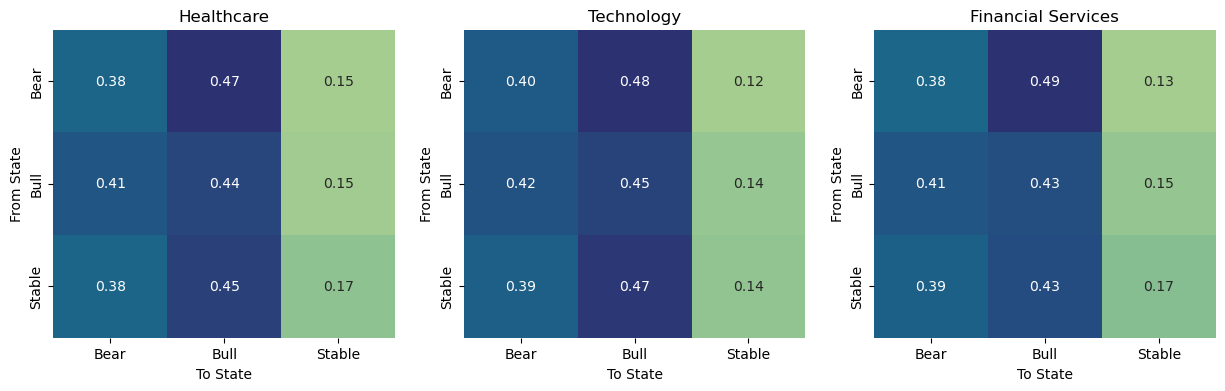

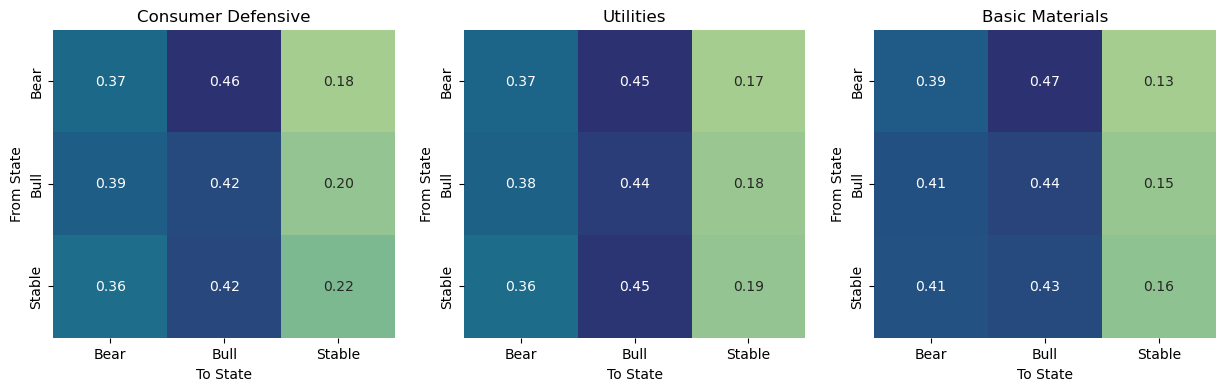

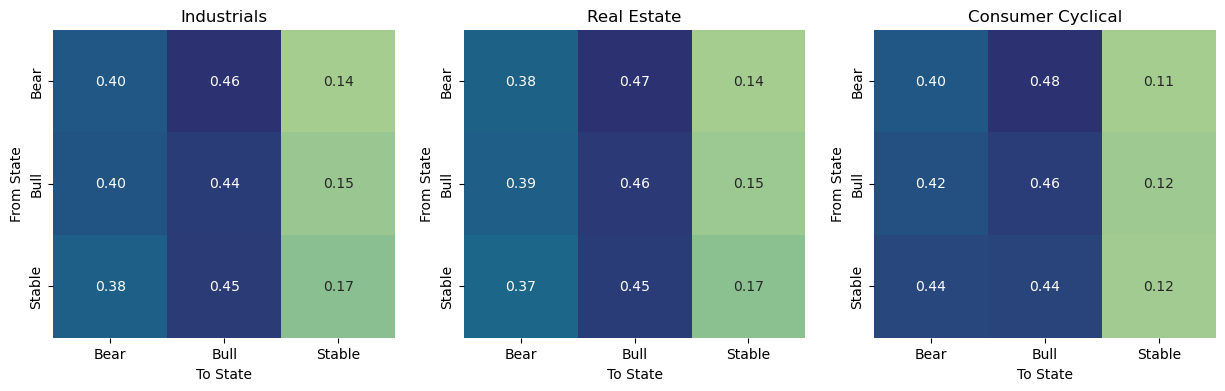

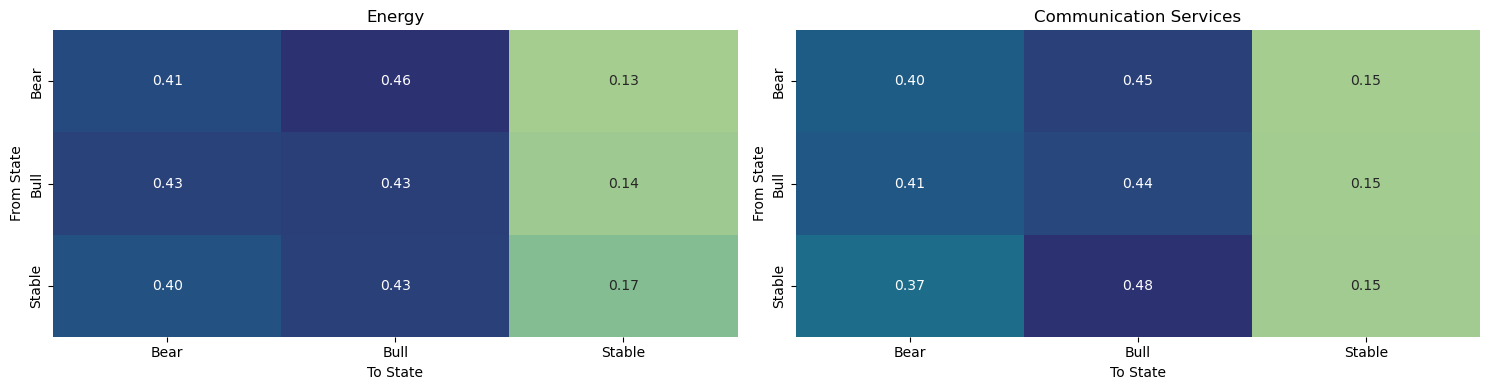

In [96]:
sectors_per_plot = 3

for i in range(0,len(sectors),sectors_per_plot):
    selected = sectors[i:i+sectors_per_plot]

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))

    for ax, sector in zip(axes, selected):
        matrix = sector_transitions[sector]
        sns.heatmap(matrix, annot=True, cmap='crest', cbar=False, fmt='.2f', ax=ax,
                    xticklabels=['Bear','Bull','Stable'], yticklabels=['Bear','Bull','Stable'])
        ax.set_title(sector)
        ax.set_xlabel('To State')
        ax.set_ylabel('From State')

plt.tight_layout()
plt.show()

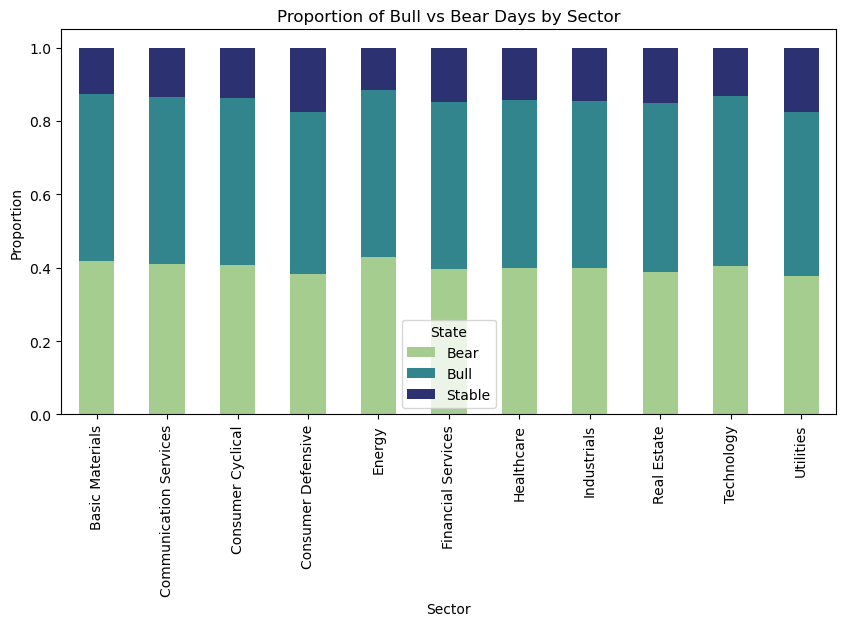

In [97]:
state_counts = (
    sp_sector.groupby(['Sector', 'State'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

state_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='crest')
plt.title('Proportion of Bull vs Bear Days by Sector')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.show()


#### Interpretation

Analysis of sector-level matrices shows that most sectors display a similar trend to individual stocks. A near-even split between Bull and Bear days, with Stable days accounting for roughly 10-20%. Certain sectors, such as Utilities and Consumer Defensive, show slightly higher proportions of Stable days. Overall, the sector-level analysis aligns with the trends observed at the individual stock level.

## Simulation and Validation

Using the test dataset (2020–2024), we simulate sector-level state sequences based on the last observed state in the training set. The simulated transition matrices are then compared to the actual transition matrices for the same period. 

In [ ]:
#Splitting the dataa into test and train sets
test  = sp_stocks[sp_stocks['Date'] >= '2020-01-01']

test = test.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [100]:
train = sp_sector
train.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
1170097,2019-12-31,XYL,74.241714,78.790001,79.120003,78.239998,78.870003,492000.0,0.000635,Stable,Industrials,28458575872,0.000512
1170098,2019-12-31,YUM,91.778305,100.730003,101.169998,100.230003,100.669998,1271000.0,0.000894,Stable,Consumer Cyclical,36937969664,0.000665
1170099,2019-12-31,ZBH,140.075439,145.320389,145.349518,143.970871,143.970871,630772.0,0.006252,Bull,Healthcare,21324808192,0.000384
1170100,2019-12-31,ZBRA,255.440002,255.440002,256.470001,253.899994,253.899994,363500.0,0.005234,Bull,Technology,20273004544,0.000365
1170101,2019-12-31,ZTS,127.484680,132.350006,132.580002,131.449997,132.009995,1128600.0,0.001059,Stable,Healthcare,74370031616,0.001338


In [101]:
test.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
620452,2024-12-20,XYL,117.139999,117.139999,118.120003,115.900002,116.070000,2799600.0,0.006098,Bull,Industrials,28458575872,0.000512
620453,2024-12-20,YUM,132.360001,132.360001,133.380005,130.139999,130.250000,3212900.0,0.015342,Bull,Consumer Cyclical,36937969664,0.000665
620454,2024-12-20,ZBH,107.120003,107.120003,107.779999,105.339996,105.339996,3969100.0,0.012381,Bull,Healthcare,21324808192,0.000384
620455,2024-12-20,ZBRA,393.040009,393.040009,395.029999,382.850006,383.350006,826400.0,0.019903,Bull,Technology,20273004544,0.000365
620456,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0,0.008072,Bull,Healthcare,74370031616,0.001338


### Simulation Phase
We take the last state from 2019 for each sector,then we simulate forward day-by-day from 2020–2024 using the training transition matrix. Each day’s next state is randomly chosen based on those pre-2020 probabilities.Finally, we compare these proportions to the real observed states.

In [102]:

def simulate_sector(start_state, transition_matrix, days):
    states = ['Bear','Bull','Stable']
    sequence = [start_state]
    for _ in range(days-1):
        probs = transition_matrix.loc[sequence[-1]].values
        next_state = random.choices(states, weights=probs, k=1)[0]
        sequence.append(next_state)
    return sequence

# Dictionary to store simulated sector states
simulated_sector_states = {}

for sector in sectors:
    # Starting state: last state from training data
    last_state = train[train['Sector']==sector].sort_values('Date')['State'].iloc[-1]
    
    # Number of days to simulate: unique dates in test for this sector
    days = test[test['Sector']==sector]['Date'].nunique()
    
    # Simulate sequence
    simulated_sector_states[sector] = simulate_sector(last_state, sector_transitions[sector], days)

# Create actual_states from the test dataset
actual_states = test[['Sector', 'State', 'Date']].copy()

# Compare simulated vs actual
for sector in sectors:
    sim_counts = pd.Series(simulated_sector_states[sector]).value_counts(normalize=True)
    actual_counts = actual_states[actual_states['Sector']==sector]['State'].value_counts(normalize=True)
    
    print(f"\nSector: {sector}")
    print("Simulated:", sim_counts.to_dict())
    print("Actual   :", actual_counts.to_dict())


Sector: Healthcare
Simulated: {'Bull': 0.48242811501597443, 'Bear': 0.3730031948881789, 'Stable': 0.14456869009584664}
Actual   : {'Bull': 0.45330431341511673, 'Bear': 0.43110407597942224, 'Stable': 0.11559161060546103}

Sector: Technology
Simulated: {'Bull': 0.46485623003194887, 'Bear': 0.41373801916932906, 'Stable': 0.12140575079872204}
Actual   : {'Bull': 0.4750329348621615, 'Bear': 0.42772383508172723, 'Stable': 0.09724323005611124}

Sector: Financial Services
Simulated: {'Bull': 0.43370607028753994, 'Bear': 0.4169329073482428, 'Stable': 0.14936102236421725}
Actual   : {'Bull': 0.469231319441133, 'Bear': 0.4195198130751991, 'Stable': 0.11124886748366793}

Sector: Consumer Defensive
Simulated: {'Bull': 0.43849840255591055, 'Bear': 0.3570287539936102, 'Stable': 0.20447284345047922}
Actual   : {'Bull': 0.4476177912626696, 'Bear': 0.4103950926719873, 'Stable': 0.1419871160653431}

Sector: Utilities
Simulated: {'Bull': 0.4488817891373802, 'Bear': 0.3761980830670926, 'Stable': 0.1749201

#### Interpretation

The results show that the simulation is able to capture the trend of the actual proportions with slight differences, maintaining the roughly equal split between Bull and Bear days, with Stable days taking 10–20%. Stable days are slightly overestimated in the simulation.

### Converting States to Price Movements

We convert the States to Price movement, by assigning percentage increase or decrease to each state.

Starting from the last training state, we simulate multiple price paths and compute the mean predicted price along with a 95% confidence interval. 

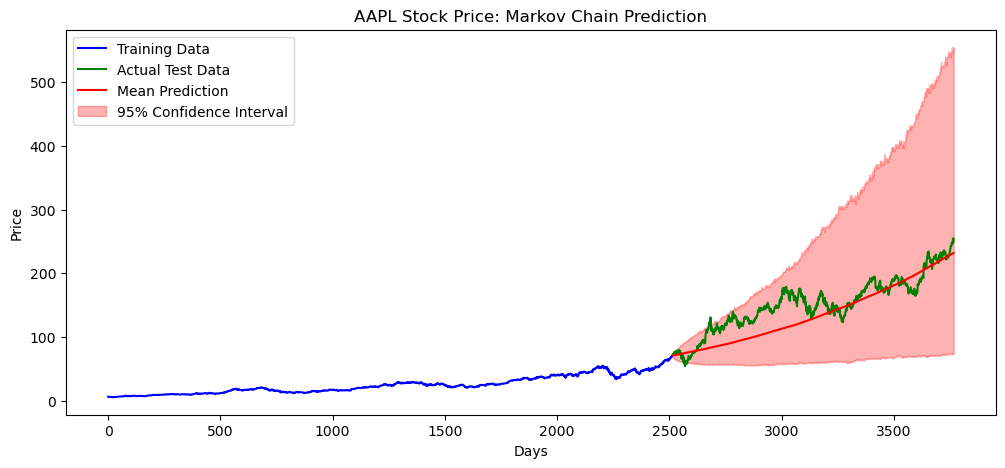

In [103]:
# Example for a single stock/sector
states = ['Bear', 'Bull', 'Stable']
state_to_return = {'Bear': -0.015, 'Stable': 0, 'Bull': 0.015}  # example daily return

# Get the last state from training as starting point
last_state = train[train['Symbol']=='AAPL'].iloc[-1]['State']
transition_matrix = transition_matrices['AAPL']  # or sector_transitions['Financial Services']

n_days = len(test[test['Symbol']=='AAPL'])
simulations = 1000  # number of simulations for CI
simulated_prices = np.zeros((simulations, n_days))

initial_price = train[train['Symbol']=='AAPL'].iloc[-1]['Adj Close']

for i in range(simulations):
    price = initial_price
    state = last_state
    for day in range(n_days):
        # Choose next state based on transition probabilities
        probs = transition_matrix.loc[state].values
        state = np.random.choice(states, p=probs)
        # Convert state to price change
        price *= 1 + state_to_return[state]
        simulated_prices[i, day] = price

# Compute mean and 95% CI
mean_pred = simulated_prices.mean(axis=0)
lower = np.percentile(simulated_prices, 2.5, axis=0)
upper = np.percentile(simulated_prices, 97.5, axis=0)

# Actual test prices
actual_prices = test[test['Symbol']=='AAPL']['Adj Close'].values
train_prices = train[train['Symbol']=='AAPL']['Adj Close'].values

# Plot
plt.figure(figsize=(12,5))
plt.plot(range(len(train_prices)), train_prices, color='blue', label='Training Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), actual_prices, color='green', label='Actual Test Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), mean_pred, color='red', label='Mean Prediction')
plt.fill_between(range(len(train_prices), len(train_prices)+len(actual_prices)), lower, upper, color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('AAPL Stock Price: Markov Chain Prediction')
plt.legend()
plt.show()


 #### Interpretation
 
 Comparing the simulated prices to actual prices shows that the mean prediction generally follows the real trend. Stocks with a clear underlying trend, like Apple, are captured more accurately, while volatile stocks are harder to predict. This limitation arises because the model only considers previous-day movements and does not account for longer-term seasonality or other external factors, especially random noise within the market.